In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import emcee

In [4]:
df = pd.read_csv('AlphaOri_AAVSO_ATEL.csv')
time = df['time'].values
mag = df['Vmag'].values
good = time < 2019.5
time = time[good]
mag = mag[good]
from astropy.timeseries import LombScargle
ls = LombScargle(time, mag)
freq, power = ls.autopower()

In [5]:
def rednoise(frequency, alpha0, tau, gamma, alphaw):
    num = alpha0
    den = 1.0 + (2*np.pi*tau*frequency)**gamma
    return num/den + alphaw

def log_rednoise(frequency, alpha0, tau, gamma, alphaw):
    return np.log10(rednoise(frequency, alpha0, tau, gamma, alphaw))

from scipy.optimize import curve_fit

def fit_rednoise(time, mag):
    # Input: time and magnitude arrays
    
    # Step 1: Calculate the Lomb-Scargle Periodogram

    ls = LombScargle(time, mag)
    freq, power =ls.autopower()
    
    # Step 1.5: Calculate the log of the lomb-scargle periodogram
    log_power = np.log10(power) 
    
    # Step 2: Curve fit red noise function
    popt,pcov = curve_fit(log_rednoise, freq, log_power, p0 = (0.05, 0.1, 2, 0.01))
    
    alpha0, tau, gamma, alphaw = popt
    err_arr = np.sqrt(np.diag(pcov)) 
    
    return (alpha0, tau, gamma, alphaw), err_arr

arg,err_arr = fit_rednoise(time, mag)

for a,e,l in zip(arg, err_arr,labels):
    print(l,f'{a:.3f}+/-{e:.3f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


NameError: name 'labels' is not defined

In [6]:
def log_likelihood(theta, frequency, logpower):
    alpha0, tau, gamma, alphaw = theta
    model = np.log10(rednoise(frequency, alpha0, tau, gamma, alphaw))
    return -0.5 * np.sum((logpower - model) ** 2)

In [7]:
def log_prior(theta):
    alpha0, tau, gamma, alphaw = theta
    if (alphaw < alpha0) & (tau > 1/365):
        return 0.0
    return -np.inf

In [8]:
def log_probability(theta, frequency, logpower):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frequency, logpower)

In [ ]:
import emcee

#arg = fit_rednoise(time, mag)

pos = arg + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(freq, np.log10(power)))
sampler.run_mcmc(pos, 5000, progress=True);

 94%|█████████▎| 4682/5000 [03:50<00:15, 20.32it/s]

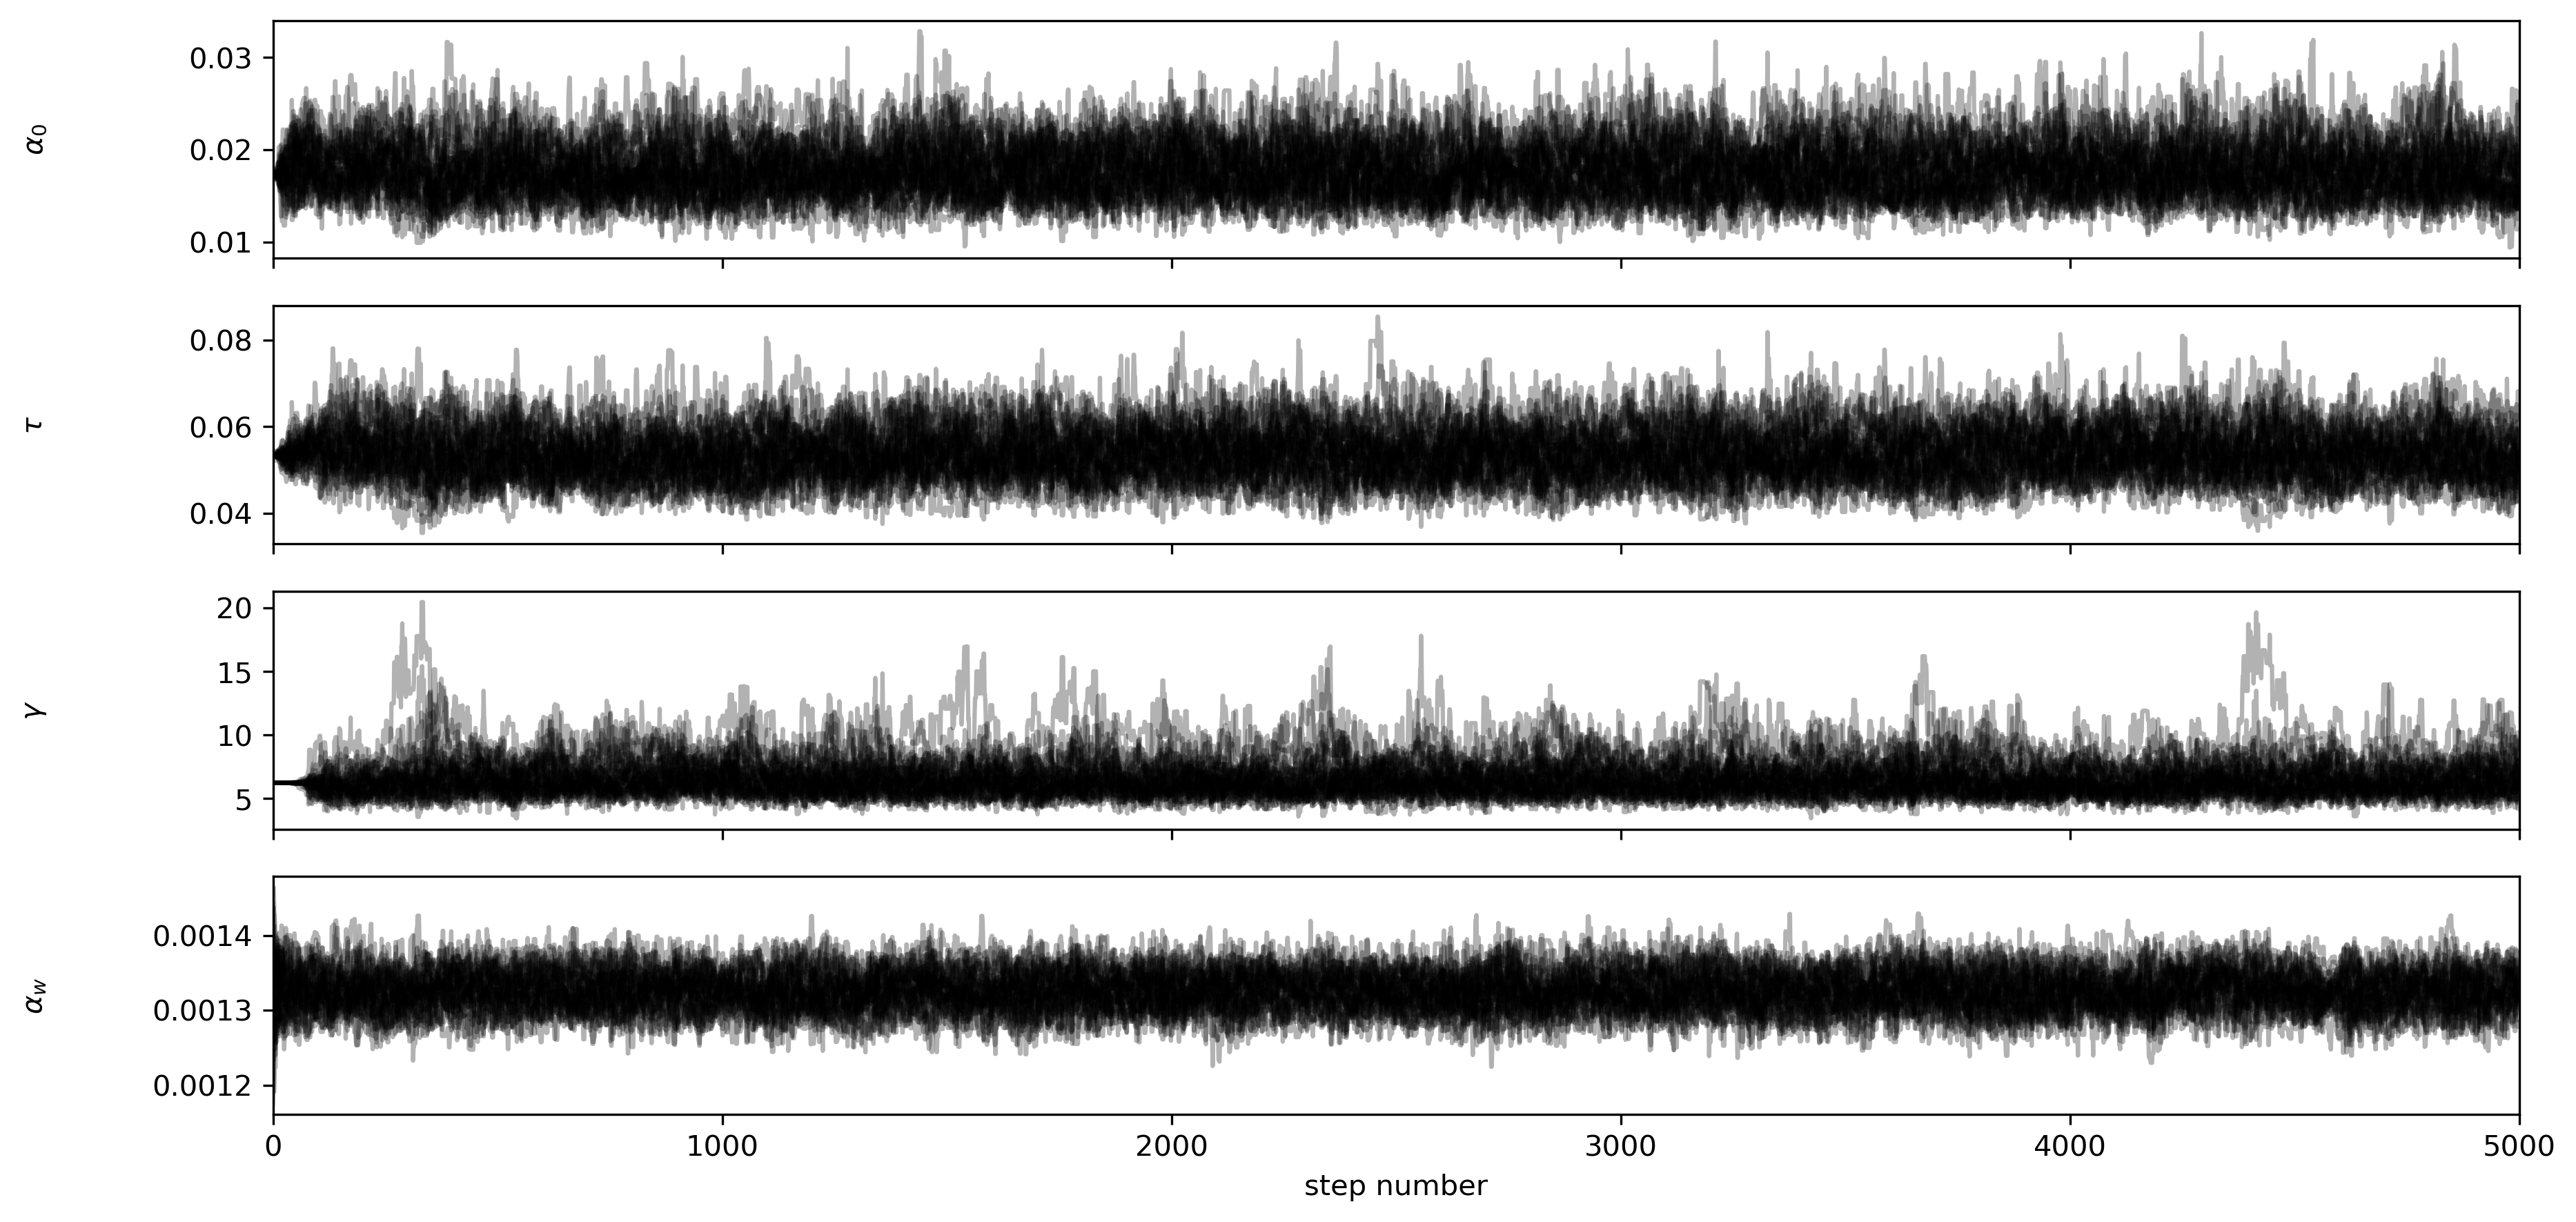

In [14]:
fig, axes = plt.subplots(4, figsize=(14, 7), sharex=True,dpi=300)
samples = sampler.get_chain()
labels = [r"$\alpha_0$", r"$\tau$", r"$\gamma$", r"$\alpha_w$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

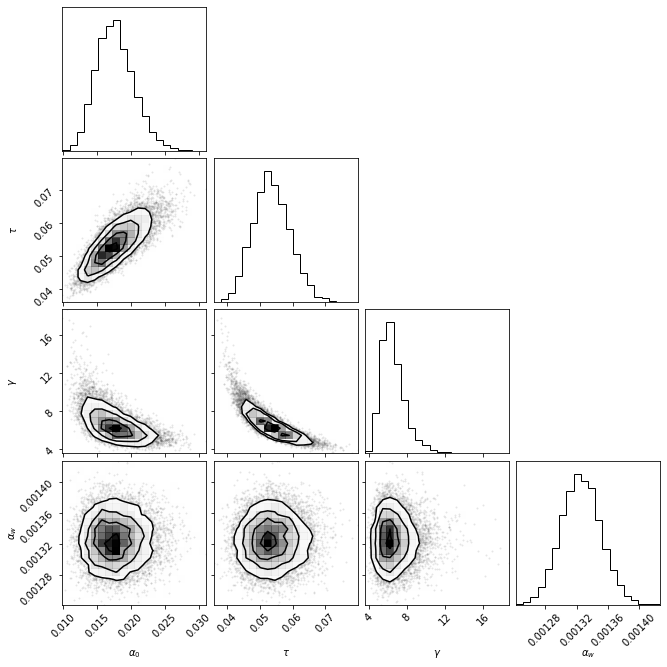

In [15]:
import corner
flat_samples = sampler.get_chain(discard=250, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=labels,dpi=300)

In [16]:
for i,val in enumerate(labels):
    print(i,val)

0 $\alpha_0$
1 $\tau$
2 $\gamma$
3 $\alpha_w$


In [17]:
for i, val in enumerate(labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(val,mcmc,f"{mcmc[1]:.3f}+{mcmc[2]-mcmc[1]:.3f}-{mcmc[1]-mcmc[0]:.3f}")

$\alpha_0$ [0.01496623 0.01756167 0.02047374] 0.018+0.003-0.003
$\tau$ [0.04805558 0.05337147 0.05922151] 0.053+0.006-0.005
$\gamma$ [5.36593571 6.30896401 7.73426941] 6.309+1.425-0.943
$\alpha_w$ [0.00130049 0.00132525 0.00135048] 0.001+0.000-0.000
